In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import lifelines
import os
from sksurv.nonparametric import kaplan_meier_estimator
from tqdm import tqdm
import geopandas as gpd
from lifelines import KaplanMeierFitter

%matplotlib widget

### Reading and formatting records

In [3]:
data_icold_r = pd.read_excel(r'.\WRD_rmduplicates.xlsx')
data_icold_fail = pd.read_excel(r'.\ICOLD_failures_full.xlsx')

data_icold = data_icold_r.sort_values(by=["Year of Completion"]).copy()
data_icold['Year of Completion'] = data_icold['Year of Completion']
data_icold.rename(columns= {'Name of the dam' :'name', 'Year of Completion' : 'year_const', 'Dam Type' : 'type', 'Height' : 'h', 'Continent': 'continent', 'Country': 'country'}, inplace = True)
data_icold.reset_index(inplace = True)
data_icold = data_icold[['name', 'year_const', 'type', 'h', 'continent', 'country']]

### Binarize DAM TYPE in the WRD (ED: earth dam, CG: concrete vault or gravity)
data_icold['type'] = [s[:2] if type(s) == str else s for s in data_icold['type']]
dam_type = []
for c in data_icold['type']:
    if c in ['TE', 'ER', 'XX']:
        dam_type.append('ED')
    elif c in ["CB", "BM", "PG", "VA", "MV"]:
        dam_type.append('CG')
    else:
        dam_type.append(np.nan)
    
data_icold['type'] = dam_type

data_icold_fail.rename(columns= {'Dam name' :'name', 'Year Incident' : 'year_fail', 'Dam type' : 'type', 'Height (m)' : 'h', 'Construction Year': 'year_const', 'Continent': 'continent', 'Country': 'country'}, inplace = True)
data_icold_fail = data_icold_fail[data_icold_fail.year_const > 0]
data_icold_fail['failure'] = np.ones(len(data_icold_fail))

### Binarize DAM TYPE in the failure dataset (ED: earth dam, CG: concrete vault or gravity)
data_icold_fail['type'] = [s[:2] for s in data_icold_fail['type']]

dam_type = []
for c in data_icold_fail['type']:
    if c in ['TE', 'ER', 'XX']:
        dam_type.append('ED')
    elif c in ["CB", "BM", "PG", "VA", "MV"]:
        dam_type.append('CG')
    
data_icold_fail['type'] = dam_type

# Homogeneize country names
cases_countries = []
for k in data_icold.country:
    for f in data_icold_fail.country.unique():
        match = False
        if f.lower() in k.lower():
            cases_countries.append(f)
            match = True
            break

    if match == False:
        if k == 'Viet Nam':
            k = 'Vietnam'
        cases_countries.append(k)

### Add failure flag
data_icold['country'] = cases_countries
data_icold['failure'] = np.zeros(len(data_icold))

### IMPORT GDP PPP data per country
gdp = pd.read_excel(r'.\GDP_ppp_WRD.xlsx', index_col=[0])[['Country' ,'GDPppp(IUSD)']]
gdp.rename(columns={'GDPppp(IUSD)':'GDP'}, inplace = True)

data_icold_sub = data_icold.iloc[[True if s in data_icold_fail.country.unique() else False for s in data_icold.country.values]].copy()

### Merge datasets
### Generate survival analysis dataset
data_surv = pd.concat([data_icold_fail, data_icold_sub], axis = 0)
data_surv.reset_index(inplace = True)
data_surv['failure'] = data_surv['failure'].astype(bool)
data_surv = data_surv[['name', 'year_const', 'h', 'failure', 'continent', 'country', 'type', 'year_fail']]
data_surv['GDP'] = np.array([gdp[gdp.Country == s].GDP.values[0] for s in data_surv.country])*1E-3  # GDP ppp in k international USD 2018

In [4]:
#### Resample each country's records on their empirical distribution (type, h, and year_const)
DATABASE_YEAR = 0
seed = 1984 ## Random seed

### resample from empirical distribution attending to each country's distribution of dam types and construction history
def fill_column_empirical_sample(dataset, col, country, seed):
    dataset.loc[(dataset.country == country) & (dataset[col].isna()), col] = dataset[dataset.country == country][~dataset[dataset.country == country][col].isna()].sample(
                    len(dataset[dataset.country == country][dataset[dataset.country == country][col].isna()]
                    ), random_state = seed, replace = True)[col].tolist()
    return dataset

data_surv_s = data_surv.copy()
for country in data_surv_s.country.unique():
    data_surv_s = fill_column_empirical_sample(data_surv_s, 'type', country, seed)
    data_surv_s = fill_column_empirical_sample(data_surv_s, 'h', country, seed)
    data_surv_s = fill_column_empirical_sample(data_surv_s, 'year_const', country, seed)

data_surv_s['time_f'] = data_surv_s.year_fail - data_surv_s.year_const
data_surv_s.loc[data_surv_s['time_f'].isna(), 'time_f'] = 2018 - data_surv_s[data_surv_s['time_f'].isna()].year_const
data_surv_s.loc[data_surv_s.time_f < 0, 'time_f'] = np.zeros(len(data_surv_s[data_surv_s.time_f < 0]))

data_surv_s = data_surv_s[(data_surv_s.year_const > DATABASE_YEAR) & (data_surv_s.year_const <= 2018)]

In [5]:
# Explore characteristics of the Survival dataset

print('Numer of dams representative of the failure dataset:', len(data_icold_sub))
print('Numer of dams in ICOLD:', len(data_icold))

print('Numer of dams representative after 1900:', len(data_surv_s[(data_surv_s.year_const >= 1900) & (data_surv_s.year_const <= 2018)]))
print('Numer of dams representative after 1900 %:', len(data_surv_s[(data_surv_s.year_const >= 1900) & (data_surv_s.year_const <= 2018)])/ len(data_icold_sub))

print('Numer of dams failed after 1900:', len(data_surv_s[(data_surv_s.year_const >= 1900) & (data_surv_s.year_const <= 2018) & (data_surv_s.failure == True)]))
print('Numer of dams failed after 0:', len(data_surv_s[(data_surv_s.year_const >= 0) & (data_surv_s.year_const <= 2018) & (data_surv_s.failure == True)]))

print('Numer of dams failed after 1900 %:', len(data_surv_s[(data_surv_s.year_const >= 1900) & (data_surv_s.year_const <= 2018) & (data_surv_s.failure == True)])/len(data_surv_s[(data_surv_s.year_const >= 0) & (data_surv_s.year_const <= 2018) & (data_surv_s.failure == True)]))

Numer of dams representative of the failure dataset: 54498
Numer of dams in ICOLD: 57866
Numer of dams representative after 1900: 53115
Numer of dams representative after 1900 %: 0.9746229219420897
Numer of dams failed after 1900: 247
Numer of dams failed after 0: 312
Numer of dams failed after 1900 %: 0.7916666666666666


In [7]:
data_surv_s[data_surv_s.failure == True]

,name,year_const,h,failure,continent,country,type,year_fail,GDP,time_f
0,REDBANK,1899.0,16.0,True,AUSTRAL-ASIA,Australia,CG,0.0,49.029106,0.0
1,SUBIACO,60.0,40.0,True,EUROPE,Italy,CG,1305.0,42.045921,1245.0
2,SAVEH,1300.0,25.0,True,ASIA,Iran,CG,1380.0,15.311633,80.0
3,GASCO,1796.0,54.0,True,EUROPE,Spain,CG,1796.0,40.256952,0.0
4,BLACKBROOK I,1797.0,28.0,True,EUROPE,United Kingdom,ED,1799.0,46.853201,2.0
...,...,...,...,...,...,...,...,...,...,...
307,HA DONG,2011.0,27.5,True,ASIA,Vietnam,ED,2014.0,9.548700,3.0
308,KREL_2,2013.0,27.0,True,ASIA,Vietnam,ED,2014.0,9.548700,1.0
309,NAM AO 7,2017.0,82.0,True,ASIA,Laos,ED,2017.0,7.592829,0.0
310,SOLAI,1980.0,25.0,True,AFRICA,Kenya,ED,2018.0,4.339775,38.0


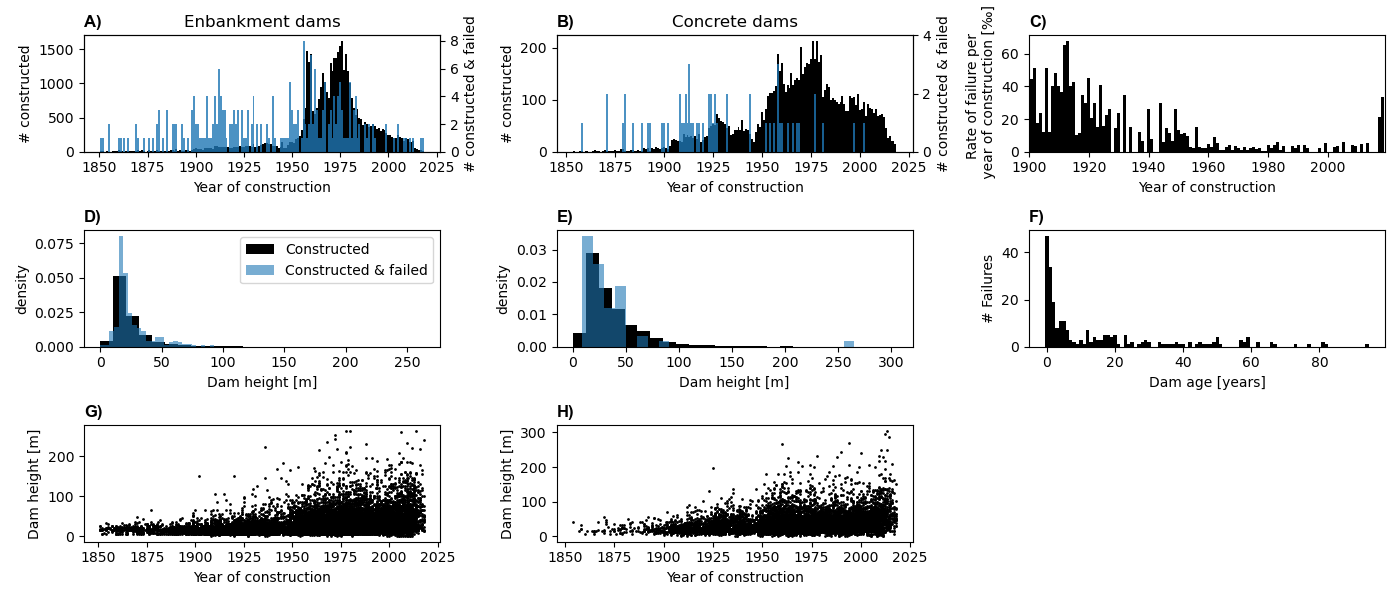

In [6]:
### SUPPLEMENTARY MATERIAL (DESCRIBE DATASET)

fig = plt.figure(figsize = (14,6))
data_surv_s_plt = data_surv_s[(data_surv_s.type == 'ED') & 
                              (data_surv_s.year_const > 1850) &  
                              (data_surv_s.year_const <= 2018)]
data_surv_s_plt2 = data_surv_s[(data_surv_s.type == 'CG') & 
                               (data_surv_s.year_const > 1850) &  
                               (data_surv_s.year_const <= 2018)]

ax0 = fig.add_subplot(331)
ax0.set_title('Enbankment dams')
ax0.set_title('A)', loc = 'left', family = 'arial', weight='bold')

ax0.bar(data_surv_s_plt[data_surv_s_plt.failure == 0].groupby('year_const').count().index, data_surv_s_plt[data_surv_s_plt.failure == 0].groupby('year_const').count().name, width= 1, color = 'k', label = 'Constructed');
ax2 = ax0.twinx()
ax2.bar(data_surv_s_plt[data_surv_s_plt.failure == 1].groupby('year_const').count().index, data_surv_s_plt[data_surv_s_plt.failure == 1].groupby('year_const').count().name, width= 1, color = 'C0', alpha = 0.8);
ax0.set_ylabel('# constructed')
ax2.set_ylabel('# constructed & failed')
ax0.set_xlabel('Year of construction')
ax2.set_yticks([0,2,4,6,8])

ax1 = fig.add_subplot(334)

ax1.hist(data_surv_s_plt[data_surv_s_plt.failure == 0]['h'], bins = 25, density=True, color = 'k', label = 'Constructed');
ax1.hist(data_surv_s_plt[data_surv_s_plt.failure == 1]['h'], bins = 25, alpha = 0.6, color = 'C0', density=True, label = 'Constructed & failed');
ax1.set_xlabel('Dam height [m]')
ax1.set_ylabel('density')
ax1.set_title('D)', loc = 'left', family = 'arial', weight='bold')

ax1.legend()

ax0 = fig.add_subplot(332)
ax0.set_title('Concrete dams')
ax0.set_title('B)', loc = 'left', family = 'arial', weight='bold')

ax0.bar(data_surv_s_plt2[data_surv_s_plt2.failure == 0].groupby('year_const').count().index, data_surv_s_plt2[data_surv_s_plt2.failure == 0].groupby('year_const').count().name, width= 1, color = 'k');
ax2 = ax0.twinx()
ax2.bar(data_surv_s_plt2[data_surv_s_plt2.failure == 1].groupby('year_const').count().index, data_surv_s_plt2[data_surv_s_plt2.failure == 1].groupby('year_const').count().name, width= 1, color = 'C0', alpha = 0.8);
ax0.set_ylabel('# constructed')
ax2.set_ylabel('# constructed & failed')
ax2.set_yticks([0,2,4])
ax0.set_xlabel('Year of construction')

ax1 = fig.add_subplot(335)
ax1.hist(data_surv_s_plt2[data_surv_s_plt2.failure == 0]['h'], bins = 25, density=True, color = 'k', label = 'Constructed');
ax1.hist(data_surv_s_plt2[data_surv_s_plt2.failure == 1]['h'], bins = 25, alpha = 0.6, color = 'C0', density=True, label = 'Constructed & failed');
ax1.set_xlabel('Dam height [m]')
ax1.set_ylabel('density')
ax1.set_title('E)', loc = 'left', family = 'arial', weight='bold')

ax = fig.add_subplot(333)
ax.bar(data_surv_s[(data_surv_s.failure == False) & (data_surv_s.year_const >= 1900)].groupby('year_const').count().index, 1000 * data_surv_s[(data_surv_s.failure == True) & (data_surv_s.year_const >= 1900)].groupby('year_const').count().h/data_surv_s[(data_surv_s.failure == False) & (data_surv_s.year_const >= 1900)].groupby('year_const').count().h, color = 'k', width = 1)
ax.set_ylabel('Rate of failure per \n year of construction [‰]')
ax.set_xlabel('Year of construction')
ax.set_xlim(1900,2019)
ax.set_title('C)', loc = 'left', family = 'arial', weight='bold')

ax = fig.add_subplot(336)
ax.bar(data_surv_s[(data_surv_s.failure == True) & (data_surv_s.year_const >= 1900)].groupby('time_f').count().index, data_surv_s[(data_surv_s.failure == True) & (data_surv_s.year_const >= 1900)].groupby('time_f').count().h, color = 'k', width = 1)
ax.set_ylabel('# Failures')
ax.set_xlabel('Dam age [years]')
ax.set_title('F)', loc = 'left', family = 'arial', weight='bold')

ax = fig.add_subplot(337)
ax.scatter(data_surv_s_plt['year_const'], data_surv_s_plt['h'], s = 1, c = 'k')
ax.set_ylabel('Dam height [m]')
ax.set_xlabel('Year of construction')
ax.set_title('G)', loc = 'left', family = 'arial', weight='bold')

ax = fig.add_subplot(338)
ax.scatter(data_surv_s_plt2['year_const'], data_surv_s_plt2['h'], s = 1, c = 'k')
ax.set_ylabel('Dam height [m]')
ax.set_xlabel('Year of construction')
ax.set_title('H)', loc = 'left', family = 'arial', weight='bold')

plt.tight_layout()

### COX-PROPORTIONAL HAZARDS AND WEIBULL AFT SURVIVAL REGRESSION MODELS

In [54]:
### MODEL 1: CPH (linear effect, all variables)

data_surv_subset = data_surv_s[(data_surv_s.country != 'China') & (data_surv_s.year_const >= 1900)].copy()
data_dummy_nc = pd.get_dummies(data_surv_subset[['time_f', 'failure', 'year_const', 'continent', 'h','type', 'GDP']], drop_first=True)

covariates = 'year_const + GDP + h + type_ED' 

cph = lifelines.CoxPHFitter().fit(data_dummy_nc, duration_col = 'time_f', event_col = 'failure', formula = covariates)

cph.print_summary()
cph.check_assumptions(data_dummy_nc, p_value_threshold=0.05, show_plots=True)

print(cph.hazard_ratios_)

<lifelines.CoxPHFitter: fitted with 29275 total observations, 29040 right-censored observations>
             duration col = 'time_f'
                event col = 'failure'
      baseline estimation = breslow
   number of observations = 29275
number of events observed = 235
   partial log-likelihood = -2307.50
         time fit was run = 2023-04-21 14:02:39 UTC

---
             coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                          
GDP         -0.01       0.99       0.00            -0.02            -0.00                 0.98                 1.00
h            0.01       1.01       0.00             0.00             0.01                 1.00                 1.01
type_ED      0.57       1.76       0.17             0.23             0.91                 1.26                 2.47
year_const  -0.03       0.97       0.00            -0.03            -0.02                 0.97                 0.98

             cmp to      z      p   -log2(p)
covariate                                   
GDP            0.00  -3.53 <0.005      11.22
h              0.00   2.96 <0.005       8.37
type_ED        0.00   3.29 <0.005       9.96
year_const     0.00 -10.97 <0.005      90.65
---
Concordance = 0.70
Partial AIC = 4623.00
log-likelihood ratio test = 116.20 on 4 df
-log2(p) of ll-ratio test = 77.94

Proportional hazard assumption looks okay.
covariate
GDP           0.988935
h             1.008063
type_ED       1.763223
year_const    0.972243
Name: exp(coef), dtype: float64


In [55]:
### MODEL 2: CPH (linear effect, year_const + h)

data_surv_subset = data_surv_s[(data_surv_s.country != 'China') & (data_surv_s.year_const >= 1900)].copy()
data_dummy_nc = pd.get_dummies(data_surv_subset[['time_f', 'failure', 'year_const', 'continent', 'h','type', 'GDP']], drop_first=True)

covariates = 'year_const + h' 

cph = lifelines.CoxPHFitter().fit(data_dummy_nc, duration_col = 'time_f', event_col = 'failure', formula = covariates)

cph.print_summary()
cph.check_assumptions(data_dummy_nc, p_value_threshold=0.05, show_plots=True)

print(cph.hazard_ratios_)


<lifelines.CoxPHFitter: fitted with 29275 total observations, 29040 right-censored observations>
             duration col = 'time_f'
                event col = 'failure'
      baseline estimation = breslow
   number of observations = 29275
number of events observed = 235
   partial log-likelihood = -2319.01
         time fit was run = 2023-04-21 14:03:23 UTC

---
             coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                          
h            0.01       1.01       0.00             0.00             0.01                 1.00                 1.01
year_const  -0.02       0.98       0.00            -0.03            -0.02                 0.97                 0.98

             cmp to     z      p   -log2(p)
covariate                                  
h              0.00  2.12   0.03       4.87
year_const     0.00 -9.85 <0.005      73.63
---
Concordance = 0.66
Partial AIC = 4642.02
log-likelihood ratio test = 93.18 on 2 df
-log2(p) of ll-ratio test = 67.22

Proportional hazard assumption looks okay.
covariate
h             1.005861
year_const    0.975530
Name: exp(coef), dtype: float64


In [56]:
### MODEL 3: CPH (linear effect, h)

data_surv_subset = data_surv_s[(data_surv_s.country != 'China') & (data_surv_s.year_const >= 1900)].copy()
data_dummy_nc = pd.get_dummies(data_surv_subset[['time_f', 'failure', 'year_const', 'continent', 'h','type', 'GDP']], drop_first=True)

covariates = 'h' 

cph = lifelines.CoxPHFitter().fit(data_dummy_nc, duration_col = 'time_f', event_col = 'failure', formula = covariates)

cph.print_summary()
cph.check_assumptions(data_dummy_nc, p_value_threshold=0.05, show_plots=True)

print(cph.hazard_ratios_)

<lifelines.CoxPHFitter: fitted with 29275 total observations, 29040 right-censored observations>
             duration col = 'time_f'
                event col = 'failure'
      baseline estimation = breslow
   number of observations = 29275
number of events observed = 235
   partial log-likelihood = -2365.46
         time fit was run = 2023-04-21 14:04:01 UTC

---
            coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                         
h           0.00       1.00       0.00            -0.00             0.01                 1.00                 1.01

            cmp to    z    p   -log2(p)
covariate                              
h             0.00 0.55 0.59       0.77
---
Concordance = 0.54
Partial AIC = 4732.91
log-likelihood ratio test = 0.29 on 1 df
-log2(p) of ll-ratio test = 0.76

Proportional hazard assumption looks okay.
covariate
h    1.001566
Name: exp(coef), dtype: float64


In [59]:
### MODEL 4: CPH (linear effect, all variables, quadratic effect in h)

data_surv_subset = data_surv_s[(data_surv_s.country != 'China') & (data_surv_s.year_const >= 1900)].copy()
data_dummy_nc = pd.get_dummies(data_surv_subset[['time_f', 'failure', 'year_const', 'continent', 'h','type', 'GDP']], drop_first=True)
data_dummy_nc['h_2'] = np.power(data_dummy_nc['h'], 2)

covariates = 'year_const + h + h_2 + type_ED + GDP' 

cph = lifelines.CoxPHFitter().fit(data_dummy_nc, duration_col = 'time_f', event_col = 'failure', formula = covariates)

cph.print_summary()
cph.check_assumptions(data_dummy_nc, p_value_threshold=0.05, show_plots=False)

print(cph.hazard_ratios_)

<lifelines.CoxPHFitter: fitted with 29275 total observations, 29040 right-censored observations>
             duration col = 'time_f'
                event col = 'failure'
      baseline estimation = breslow
   number of observations = 29275
number of events observed = 235
   partial log-likelihood = -2306.33
         time fit was run = 2023-04-21 14:29:41 UTC

---
             coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                          
GDP         -0.01       0.99       0.00            -0.02            -0.00                 0.98                 1.00
h            0.02       1.02       0.01             0.00             0.03                 1.00                 1.03
h_2         -0.00       1.00       0.00            -0.00             0.00                 1.00                 1.00
type_ED      0.61       1.84       0.17             0.27             0.95                 1.31                 2.59
year_const  -0.03       0.97       0.00            -0.03            -0.02                 0.97                 0.98

             cmp to      z      p   -log2(p)
covariate                                   
GDP            0.00  -3.51 <0.005      11.12
h              0.00   2.38   0.02       5.86
h_2            0.00  -1.32   0.19       2.43
type_ED        0.00   3.49 <0.005      11.00
year_const     0.00 -11.06 <0.005      92.00
---
Concordance = 0.70
Partial AIC = 4622.66
log-likelihood ratio test = 118.54 on 5 df
-log2(p) of ll-ratio test = 77.05

The ``p_value_threshold`` is set at 0.05. Even under the null hypothesis of no violations, some
covariates will be below the threshold by chance. This is compounded when there are many covariates.
Similarly, when there are lots of observations, even minor deviances from the proportional hazard
assumption will be flagged.

With that in mind, it's best to use a combination of statistical tests and visual tests to determine
the most serious violations. Produce visual plots using ``check_assumptions(..., show_plots=True)``
and looking for non-constant lines. See link [A] below for a full example.



<lifelines.StatisticalResult: proportional_hazard_test>
 null_distribution = chi squared
degrees_of_freedom = 1
             model = <lifelines.CoxPHFitter: fitted with 29275 total observations, 29040 right-censored observations>
         test_name = proportional_hazard_test

---
                 test_statistic    p  -log2(p)
GDP        km              0.45 0.50      1.00
           rank            1.68 0.19      2.36
h          km              3.54 0.06      4.06
           rank            4.74 0.03      5.08
h_2        km              1.23 0.27      1.91
           rank            2.08 0.15      2.74
type_ED    km              1.23 0.27      1.90
           rank            0.95 0.33      1.60
year_const km              0.04 0.84      0.25
           rank            0.35 0.56      0.85



1. Variable 'h' failed the non-proportional test: p-value is 0.0295.

   Advice 1: the functional form of the variable 'h' might be incorrect. That is, there may be non-
linear terms missing. The proportional hazard test used is very sensitive to incorrect functional
forms. See documentation in link [D] below on how to specify a functional form.

   Advice 2: try binning the variable 'h' using pd.cut, and then specify it in `strata=['h', ...]`
in the call in `.fit`. See documentation in link [B] below.

   Advice 3: try adding an interaction term with your time variable. See documentation in link [C]
below.


---
[A]  https://lifelines.readthedocs.io/en/latest/jupyter_notebooks/Proportional%20hazard%20assumption.html
[B]  https://lifelines.readthedocs.io/en/latest/jupyter_notebooks/Proportional%20hazard%20assumption.html#Bin-variable-and-stratify-on-it
[C]  https://lifelines.readthedocs.io/en/latest/jupyter_notebooks/Proportional%20hazard%20assumption.html#Introduce-time-varying-cova

In [60]:
### MODEL 5: CPH (linear effect, all variables, non-linear model year_const)

data_surv_subset = data_surv_s[(data_surv_s.country != 'China') & (data_surv_s.year_const >= 1900)].copy()
data_dummy_nc = pd.get_dummies(data_surv_subset[['time_f', 'failure', 'year_const', 'continent', 'h','type', 'GDP']], drop_first=True)
data_dummy_nc['h_2'] = np.power(data_dummy_nc['h'], 2)

covariates = 'bs(year_const, df=3, lower_bound=1900, upper_bound=2020) + h + type_ED + GDP' 

cph = lifelines.CoxPHFitter().fit(data_dummy_nc, duration_col = 'time_f', event_col = 'failure', formula = covariates)

cph.print_summary()
cph.check_assumptions(data_dummy_nc, p_value_threshold=0.05, show_plots=False)

print(cph.hazard_ratios_)

<lifelines.CoxPHFitter: fitted with 29275 total observations, 29040 right-censored observations>
             duration col = 'time_f'
                event col = 'failure'
      baseline estimation = breslow
   number of observations = 29275
number of events observed = 235
   partial log-likelihood = -2305.10
         time fit was run = 2023-04-21 14:31:13 UTC

---
                                                              coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                                                           
GDP                                                          -0.01       0.99       0.00            -0.02            -0.00                 0.98                 1.00
bs(year_const, df=3, lower_bound=1900, upper_bound=2020)[1]  -0.82       0.44       0.79            -2.37             0.72                 0.09                 2.05
bs(year_const, df=3, lower_bound=1900, upper_bound=2020)[2]  -3.40       0.03       0.65            -4.66            -2.13                 0.01                 0.12
bs(year_const, df=3, lower_bound=1900, upper_bound=2020)[3]  -2.15       0.12       0.71            -3.55            -0.76                 0.03                 0.47
h                                                             0.01       1.01       0.00             0.00             0.01                 1.00                 1.01
type_ED                                                       0.56       1.76       0.17             0.22             0.90                 1.25                 2.46

                                                              cmp to     z      p   -log2(p)
covariate                                                                                   
GDP                                                             0.00 -3.18 <0.005       9.41
bs(year_const, df=3, lower_bound=1900, upper_bound=2020)[1]     0.00 -1.05   0.30       1.76
bs(year_const, df=3, lower_bound=1900, upper_bound=2020)[2]     0.00 -5.25 <0.005      22.65
bs(year_const, df=3, lower_bound=1900, upper_bound=2020)[3]     0.00 -3.03 <0.005       8.66
h                                                               0.00  2.86 <0.005       7.88
type_ED                                                         0.00  3.25 <0.005       9.75
---
Concordance = 0.71
Partial AIC = 4622.20
log-likelihood ratio test = 121.01 on 6 df
-log2(p) of ll-ratio test = 76.40

Proportional hazard assumption looks okay.
covariate
GDP                                                            0.989810
bs(year_const, df=3, lower_bound=1900, upper_bound=2020)[1]    0.438391
bs(year_const, df=3, lower_bound=1900, upper_bound=2020)[2]    0.033513
bs(year_const, df=3, lower_bound=1900, upper_bound=2020)[3]    0.116206
h                                                              1.007813
type_ED                                                        1.755134
Name: exp(coef), dtype: float64


In [63]:
### MODEL 6: CPH (linear effect, all variables, non-linear model year_const, non-linear model h)

data_surv_subset = data_surv_s[(data_surv_s.country != 'China') & (data_surv_s.year_const >= 1900)].copy()
data_dummy_nc = pd.get_dummies(data_surv_subset[['time_f', 'failure', 'year_const', 'continent', 'h','type', 'GDP']], drop_first=True)
data_dummy_nc['h_2'] = np.power(data_dummy_nc['h'], 2)

covariates = 'bs(year_const, df=3, lower_bound=1900, upper_bound=2020) + h + h_2 + type_ED + GDP' 

cph = lifelines.CoxPHFitter().fit(data_dummy_nc, duration_col = 'time_f', event_col = 'failure', formula = covariates)

cph.print_summary()
cph.check_assumptions(data_dummy_nc, p_value_threshold=0.05, show_plots=False)

print(cph.hazard_ratios_)

<lifelines.CoxPHFitter: fitted with 29275 total observations, 29040 right-censored observations>
             duration col = 'time_f'
                event col = 'failure'
      baseline estimation = breslow
   number of observations = 29275
number of events observed = 235
   partial log-likelihood = -2303.91
         time fit was run = 2023-04-21 14:32:20 UTC

---
                                                              coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                                                           
GDP                                                          -0.01       0.99       0.00            -0.02            -0.00                 0.98                 1.00
bs(year_const, df=3, lower_bound=1900, upper_bound=2020)[1]  -0.89       0.41       0.79            -2.44             0.66                 0.09                 1.93
bs(year_const, df=3, lower_bound=1900, upper_bound=2020)[2]  -3.41       0.03       0.65            -4.68            -2.14                 0.01                 0.12
bs(year_const, df=3, lower_bound=1900, upper_bound=2020)[3]  -2.23       0.11       0.71            -3.63            -0.83                 0.03                 0.44
h                                                             0.02       1.02       0.01             0.00             0.03                 1.00                 1.03
h_2                                                          -0.00       1.00       0.00            -0.00             0.00                 1.00                 1.00
type_ED                                                       0.60       1.83       0.18             0.26             0.95                 1.30                 2.58

                                                              cmp to     z      p   -log2(p)
covariate                                                                                   
GDP                                                             0.00 -3.16 <0.005       9.33
bs(year_const, df=3, lower_bound=1900, upper_bound=2020)[1]     0.00 -1.13   0.26       1.95
bs(year_const, df=3, lower_bound=1900, upper_bound=2020)[2]     0.00 -5.27 <0.005      22.82
bs(year_const, df=3, lower_bound=1900, upper_bound=2020)[3]     0.00 -3.13 <0.005       9.14
h                                                               0.00  2.36   0.02       5.77
h_2                                                             0.00 -1.34   0.18       2.46
type_ED                                                         0.00  3.44 <0.005      10.76
---
Concordance = 0.71
Partial AIC = 4621.82
log-likelihood ratio test = 123.38 on 7 df
-log2(p) of ll-ratio test = 75.81

The ``p_value_threshold`` is set at 0.05. Even under the null hypothesis of no violations, some
covariates will be below the threshold by chance. This is compounded when there are many covariates.
Similarly, when there are lots of observations, even minor deviances from the proportional hazard
assumption will be flagged.

With that in mind, it's best to use a combination of statistical tests and visual tests to determine
the most serious violations. Produce visual plots using ``check_assumptions(..., show_plots=True)``
and looking for non-constant lines. See link [A] below for a full example.



<lifelines.StatisticalResult: proportional_hazard_test>
 null_distribution = chi squared
degrees_of_freedom = 1
             model = <lifelines.CoxPHFitter: fitted with 29275 total observations, 29040 right-censored observations>
         test_name = proportional_hazard_test

---
                                                                  test_statistic    p  -log2(p)
GDP                                                         km              0.71 0.40      1.32
                                                            rank            1.99 0.16      2.66
bs(year_const, df=3, lower_bound=1900, upper_bound=2020)[1] km              0.27 0.60      0.74
                                                            rank            0.55 0.46      1.13
bs(year_const, df=3, lower_bound=1900, upper_bound=2020)[2] km              1.18 0.28      1.85
                                                            rank            1.96 0.16      2.63
bs(year_const, df=3, lower_bound=1900, upper_bound=2020)[3] km              0.70 0.40      1.31
                                                            rank            0.41 0.52      0.93
h                                                           km              3.28 0.07      3.83
                                                            rank            4.39 0.04      4.79
h_2                                                         km              1.18 0.28      1.85
                                                            rank            1.98 0.16      2.65
type_ED                                                     km              1.30 0.25      1.98
                                                            rank            1.08 0.30      1.75



1. Variable 'h' failed the non-proportional test: p-value is 0.0361.

   Advice 1: the functional form of the variable 'h' might be incorrect. That is, there may be non-
linear terms missing. The proportional hazard test used is very sensitive to incorrect functional
forms. See documentation in link [D] below on how to specify a functional form.

   Advice 2: try binning the variable 'h' using pd.cut, and then specify it in `strata=['h', ...]`
in the call in `.fit`. See documentation in link [B] below.

   Advice 3: try adding an interaction term with your time variable. See documentation in link [C]
below.


---
[A]  https://lifelines.readthedocs.io/en/latest/jupyter_notebooks/Proportional%20hazard%20assumption.html
[B]  https://lifelines.readthedocs.io/en/latest/jupyter_notebooks/Proportional%20hazard%20assumption.html#Bin-variable-and-stratify-on-it
[C]  https://lifelines.readthedocs.io/en/latest/jupyter_notebooks/Proportional%20hazard%20assumption.html#Introduce-time-varying-cova

In [65]:
### MODEL 7: Weibull ATF (linear effect, all variables, non-linear model year_const, non-linear model h)

data_surv_subset = data_surv_s[(data_surv_s.country != 'China') & (data_surv_s.year_const >= 1900)].copy()
data_dummy_nc = pd.get_dummies(data_surv_subset[['time_f', 'failure', 'year_const', 'continent', 'h','type', 'GDP']], drop_first=True)
data_dummy_nc['h_2'] = np.power(data_dummy_nc['h'], 2)
data_dummy_nc.loc[data_dummy_nc['time_f'] == 0, 'time_f'] += 0.001  ### (add a small delta t, since the Weibull fitting can not accomodate 0s)

covariates = 'bs(year_const, df=3, lower_bound=1900, upper_bound=2020) + h + h_2 + type_ED + GDP' 

wf = lifelines.WeibullAFTFitter().fit(data_dummy_nc, "time_f", "failure", fit_intercept = False, formula = covariates)

wf.print_summary()

print(wf.hazard_ratios_)

<lifelines.WeibullAFTFitter: fitted with 29275 total observations, 29040 right-censored observations>
             duration col = 'time_f'
                event col = 'failure'
   number of observations = 29275
number of events observed = 235
           log-likelihood = -1918.70
         time fit was run = 2023-04-21 14:33:44 UTC

---
                                                                      coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
param   covariate                                                                                                                                                           
lambda_ Intercept                                                    17.60   4.38e+07       1.53            14.60            20.59             2.19e+06             8.75e+08
        GDP                                                           0.04       1.04       0.01             0.01             0.06                 1.01                 1.06
        bs(year_const, df=3, lower_bound=1900, upper_bound=2020)[1]   2.49      12.00       2.94            -3.28             8.25                 0.04              3811.93
        bs(year_const, df=3, lower_bound=1900, upper_bound=2020)[2]  12.91   4.04e+05       2.52             7.97            17.85              2899.15             5.62e+07
        bs(year_const, df=3, lower_bound=1900, upper_bound=2020)[3]   8.01    3003.70       2.74             2.64            13.38                13.95             6.47e+05
        h                                                            -0.07       0.93       0.03            -0.13            -0.01                 0.88                 0.99
        h_2                                                           0.00       1.00       0.00            -0.00             0.00                 1.00                 1.00
        type_ED                                                      -2.24       0.11       0.67            -3.55            -0.93                 0.03                 0.39
rho_    Intercept                                                    -1.31       0.27       0.07            -1.44            -1.18                 0.24                 0.31

                                                                      cmp to      z      p   -log2(p)
param   covariate                                                                                    
lambda_ Intercept                                                       0.00  11.52 <0.005      99.55
        GDP                                                             0.00   3.10 <0.005       8.99
        bs(year_const, df=3, lower_bound=1900, upper_bound=2020)[1]     0.00   0.85   0.40       1.33
        bs(year_const, df=3, lower_bound=1900, upper_bound=2020)[2]     0.00   5.13 <0.005      21.68
        bs(year_const, df=3, lower_bound=1900, upper_bound=2020)[3]     0.00   2.92 <0.005       8.16
        h                                                               0.00  -2.34   0.02       5.68
        h_2                                                             0.00   1.33   0.18       2.46
        type_ED                                                         0.00  -3.36 <0.005      10.31
rho_    Intercept                                                       0.00 -20.16 <0.005     297.69
---
Concordance = 0.71
AIC = 3855.40
log-likelihood ratio test = 152.02 on 7 df
-log2(p) of ll-ratio test = 95.72

param    covariate                                                  
lambda_  Intercept                                                      4.382273e+07
         GDP                                                            1.038633e+00
         bs(year_const, df=3, lower_bound=1900, upper_bound=2020)[1]    1.200177e+01
         bs(year_const, df=3, lower_bound=1900, upper_bound=2020)[2]    4.038275e+05
         bs(year_const, df=3, lower_bound=1900, upper_bound=2020)[3]    3.003699e+03
         h                                                              9.340970e-01
         h_2                                                            1.000297e+00
         type_ED                                                        1.061592e-01
rho_     Intercept                                                      2.692965e-01
Name: exp(coef), dtype: float64


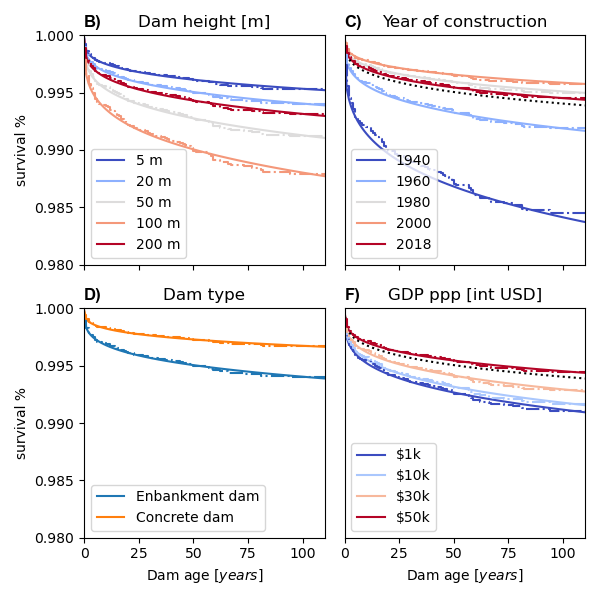

In [67]:
### Plotting partial effects

fig = plt.figure(figsize = (6,6))

lim_x = 110
lim_y = 0.98

ax0 = fig.add_subplot(221)

wf.plot_partial_effects_on_outcome(
    covariates=['h', 'h_2'],
    values=[
        [5, 25],
        [20, 400],
        [50, 2500],
        [100, 10000],
        [200, 40000],
    ], cmap='coolwarm',ax = ax0, plot_baseline=False)

cph.plot_partial_effects_on_outcome(
    covariates=['h', 'h_2'],
    values=[
        [5, 25],
        [20, 400],
        [50, 2500],
        [100, 10000],
        [200, 40000],
    ], cmap='coolwarm',ax = ax0, plot_baseline=False, linestyle = '-.')

ax0.set_ylim(lim_y,1)
ax0.set_xlim(0, lim_x)
ax0.set_xlabel('dam age')
ax0.set_ylabel("survival %")
ax0.legend(labels = ['5 m','20 m','50 m','100 m', '200 m'])
ax0.set_title('B)', loc = 'left', family = 'arial', weight='bold')
ax0.set_title('Dam height [m]', loc='center', fontsize='large')
ax0.set_xlabel("Dam age [years]")

ax1 = fig.add_subplot(222, sharex = ax0)

wf.plot_partial_effects_on_outcome(covariates='year_const', values=np.array([1940,1960,1980,2000,2018]), cmap='coolwarm',ax = ax1)
cph.plot_partial_effects_on_outcome(covariates='year_const', values=np.array([1940,1960,1980,2000,2018]), cmap='coolwarm',ax = ax1, plot_baseline=False, linestyle = '-.', alpha = 1)

ax1.set_ylim(lim_y,1)
ax1.set_xlim(0, lim_x)
ax1.set_xlabel('Dam age [years]')
ax1.legend(labels = [1940,1960,1980,2000,2018])
ax1.set_title('C)', loc = 'left', family = 'arial', weight='bold')
ax1.set_title('Year of construction', loc='center', fontsize='large')
ax1.set_xlabel("Dam age [years]")
ax1.set_yticks([])


ax2 = fig.add_subplot(223)

wf.plot_partial_effects_on_outcome(covariates=["type_ED"], values = [1], plot_baseline=False, ax = ax2, color = 'C0')
wf.plot_partial_effects_on_outcome(covariates=["type_ED"], values = [0], plot_baseline=False, ax = ax2, color = 'C1')

cph.plot_partial_effects_on_outcome(covariates=["type_ED"], values = [1], plot_baseline=False, ax = ax2, linestyle = '-.', alpha = 1)
cph.plot_partial_effects_on_outcome(covariates=["type_ED"], values = [0], plot_baseline=False, ax = ax2, linestyle = '-.', alpha = 1)

ax2.set_ylabel("survival %")
ax2.set_xlabel("Dam age $[years]$")
ax2.legend(labels = ['Enbankment dam', 'Concrete dam'])
ax2.set_ylim(lim_y,1)
ax2.set_xlim(0, lim_x)
ax2.set_title('D)', loc = 'left', family = 'arial', weight='bold')
ax2.set_title('Dam type', loc='center', fontsize='large')

ax2 = fig.add_subplot(224)

wf.plot_partial_effects_on_outcome(covariates='GDP', values=[3,10,25,50], cmap='coolwarm',ax = ax2, linestyle = '-')
cph.plot_partial_effects_on_outcome(covariates='GDP', values=[3,10,25,50], cmap='coolwarm',ax = ax2, plot_baseline=False, linestyle = '-.', alpha = 1)

# ax2.set_ylabel("$\hat{S}(t)$")
ax2.set_xlabel("Dam age $[years]$")
ax2.legend(labels = ['$1k','$10k','$30k','$50k'])
ax2.set_ylim(lim_y,1)
ax2.set_xlim(0, lim_x)
ax2.set_title('F)', loc = 'left', family = 'arial', weight='bold')
ax2.set_title('GDP ppp [int USD]', loc='center', fontsize='large')
ax2.set_yticks([])

fig.tight_layout()


### Uncertainties of the non-linear models fit to the observations

We test the effect of subsampling the current dataset on the non-linear fit of the height and year_const models. This is configured as a bootstrapping strategy with 500 random samples of 70% of the data. This allows testing how sensitive are the models to individual records (e.g. not so many samples with height > 200 m).

In [68]:
### EFECT ON YEAR OF CONSTRUCTION

np.random.seed(123)

frac = 0.70
logeffect = []
logeffect_LV = []

for i in tqdm(range(500)):
    data_surv_subset = data_surv_s[(data_surv_s.country != 'China') & 
                                   (data_surv_s.year_const >= 1900) & 
                                   (data_surv_s.year_const <= 2018)].sample(frac=frac).copy()
    data_surv_subset_LV = data_surv_s[(data_surv_s.country != 'China') & 
                                      (data_surv_s.year_const >= 1900) & (data_surv_s.year_const <= 2010)].sample(frac=frac).copy()
    
    data_dummy_nochina = pd.get_dummies(data_surv_subset[['time_f', 'failure', 'year_const', 'continent', 'h','type', 'GDP']], drop_first=True)
    data_dummy_nochina_LV = pd.get_dummies(data_surv_subset_LV[['time_f', 'failure', 'year_const', 'continent', 'h','type', 'GDP']], drop_first=True)

    data_dummy2 = data_dummy_nochina.copy()
    data_dummy2.loc[data_dummy2['time_f'] == 0, 'time_f']  

    data_dummy2_LV = data_dummy_nochina_LV.copy()
    
    covariates = 'year_const + GDP + h + type_ED' 
    covariates_spline = 'bs(year_const, df=3, lower_bound=1900, upper_bound=2020) + GDP + h + type_ED' 

    cph_spline = lifelines.CoxPHFitter().fit(data_dummy2, duration_col = 'time_f', event_col = 'failure', formula = covariates_spline)
    cph_spline_LV = lifelines.CoxPHFitter().fit(data_dummy2_LV, duration_col = 'time_f', event_col = 'failure', formula = covariates_spline)

    ### plot spline effect
    age_range = np.linspace(1900, 2020, 50)

    # need to create a matrix of variables at their means, _except_ for age. 
    x_bar = cph_spline._central_values
    df_varying_age = pd.concat([x_bar] * 50).reset_index(drop=True)
    df_varying_age['year_const'] = age_range

    logeffect.append(cph_spline.predict_log_partial_hazard(df_varying_age))
    logeffect_LV.append(cph_spline_LV.predict_log_partial_hazard(df_varying_age))

logeffect = np.array(logeffect)
logeffect_LV = np.array(logeffect_LV)


100%|██████████| 500/500 [02:44<00:00,  3.04it/s]


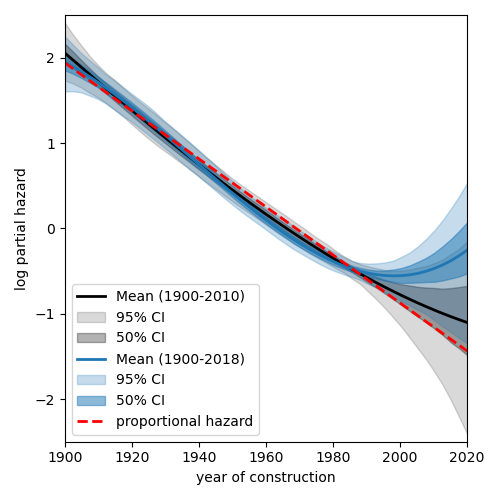

In [70]:
data_surv_subset = data_surv_s[(data_surv_s.country != 'China') & (data_surv_s.year_const >= 1900)].copy()

data_dummy_nochina = pd.get_dummies(data_surv_subset[['time_f', 'failure', 'year_const', 'continent', 'h','type', 'GDP']], drop_first=True)

data_dummy2 = data_dummy_nochina.copy()
data_dummy2['time_f'] = data_dummy2['time_f'] 

covariates = 'year_const + GDP + h + type_ED' 
covariates_spline = 'bs(year_const, df=3, lower_bound=1900, upper_bound=2020) + GDP + h + type_ED' 

cph = lifelines.CoxPHFitter().fit(data_dummy2, duration_col = 'time_f', event_col = 'failure', formula = covariates)
cph_spline = lifelines.CoxPHFitter().fit(data_dummy2, duration_col = 'time_f', event_col = 'failure', formula = covariates_spline)

fig = plt.figure(figsize = (5,5))

ax2 = fig.add_subplot(111)

ax2.plot(df_varying_age['year_const'], np.mean(logeffect_LV, axis = 0), color = 'k', lw = 2, label = r'Mean (1900-2010)')
plt.fill_between(df_varying_age['year_const'], np.percentile(logeffect_LV, 2.5, axis = 0), np.percentile(logeffect_LV, 97.5, axis = 0), color = 'k', alpha = 0.15, label = '95% CI')
plt.fill_between(df_varying_age['year_const'], np.percentile(logeffect_LV, 25, axis = 0), np.percentile(logeffect_LV, 75, axis = 0), color = 'k', alpha = 0.30, label = '50% CI')

ax2.plot(df_varying_age['year_const'], np.mean(logeffect, axis = 0), lw = 2, label = 'Mean (1900-2018)')
plt.fill_between(df_varying_age['year_const'], np.percentile(logeffect, 2.5, axis = 0), np.percentile(logeffect, 97.5, axis = 0), color = 'C0', alpha = 0.25, label = '95% CI')
plt.fill_between(df_varying_age['year_const'], np.percentile(logeffect, 25, axis = 0), np.percentile(logeffect, 75, axis = 0), color = 'C0', alpha = 0.50, label = '50% CI')

ax2.plot(df_varying_age['year_const'], cph.predict_log_partial_hazard(df_varying_age), '--r', lw = 2, label = 'proportional hazard')

ax2.legend(loc = 3)

ax2.set_xlabel('year of construction')
ax2.set_ylabel('log partial hazard')

ax2.set_ylim(-2.5, 2.5)
ax2.set_xlim(1900, 2020)
plt.tight_layout()

In [72]:
### EFECT ON YEAR OF CONSTRUCTION

np.random.seed(123)
from patsy import dmatrix

frac = 0.70
logeffect = []
logeffect_NLc = []

for i in tqdm(range(500)):

    data_surv_subset = data_surv_s[(data_surv_s.country != 'China') & (data_surv_s.year_const >= 1900)].copy()

    data_dummy_nochina = pd.get_dummies(data_surv_subset[['time_f', 'failure', 'year_const', 'continent', 'h','type', 'GDP']], drop_first=True)

    data_dummy2 = data_dummy_nochina.sample(frac=frac, replace=False)

    covariates2 = 'bs(year_const, df=3, lower_bound=1900, upper_bound=2020) + h + type_ED + GDP' 
    cph2 = lifelines.CoxPHFitter().fit(data_dummy2, duration_col = 'time_f', event_col = 'failure', formula = covariates2)

    data_dummy2['h_2'] = np.power(data_dummy2['h'], 2)
    covariates2NL = 'bs(year_const, df=3, lower_bound=1900, upper_bound=2020) + h + h_2 + type_ED + GDP' 
    cph4 = lifelines.CoxPHFitter(penalizer=0.0001).fit(data_dummy2, duration_col = 'time_f', event_col = 'failure', formula = covariates2NL)

    ### plot spline effect
    age_range = np.linspace(0, 340, 50)

    # need to create a matrix of variables at their means, _except_ for age. 
    x_bar = cph4._central_values
    df_varying_age = pd.concat([x_bar] * 50).reset_index(drop=True)
    df_varying_age['h'] = age_range

    logeffect.append(cph2.predict_log_partial_hazard(df_varying_age))
    # logeffect_NL.append(cph3.predict_log_partial_hazard(df_varying_age))

    df_varying_age['h_2'] = np.power(df_varying_age['h'], 2)
    df_varying_age['Intercept'] = np.ones(len(age_range))

    logeffect_NLc.append(cph4.predict_log_partial_hazard(df_varying_age))

logeffect = np.array(logeffect)
logeffect_NLc = np.array(logeffect_NLc)


100%|██████████| 500/500 [02:45<00:00,  3.03it/s]


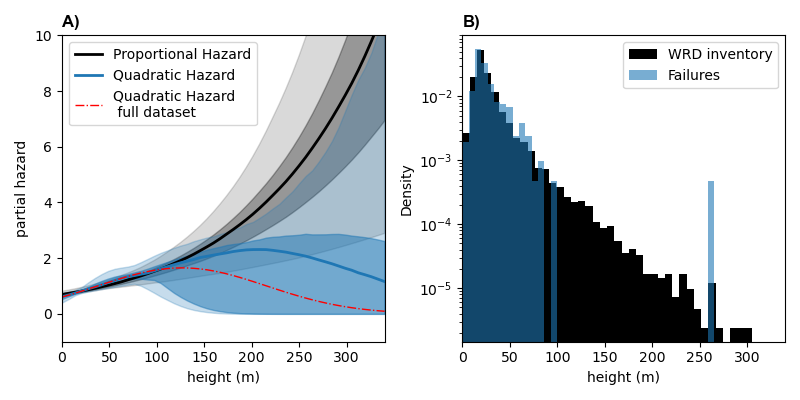

In [73]:
data_surv_subset = data_surv_s[(data_surv_s.country != 'China') & (data_surv_s.year_const >= 1900)].copy()

data_dummy_nochina = pd.get_dummies(data_surv_subset[['time_f', 'failure', 'year_const', 'continent', 'h','type', 'GDP']], drop_first=True)

data_dummy2 = data_dummy_nochina

data_dummy2['h_2'] = np.power(data_dummy2['h'], 2)

covariates2NL = 'bs(year_const, df=3, lower_bound=1900, upper_bound=2020) + h + h_2 + type_ED + GDP' 
cph_fullseries = lifelines.CoxPHFitter(penalizer=0.0001).fit(data_dummy2, duration_col = 'time_f', event_col = 'failure', formula = covariates2NL)

fig = plt.figure(figsize = (8,4))

ax2 = fig.add_subplot(121)

ax2.plot(df_varying_age['h'], np.exp(np.percentile(logeffect, 50, axis = 0)), color = 'k', lw = 2, label = 'Proportional Hazard')
ax2.plot(df_varying_age['h'], np.exp(np.percentile(logeffect_NLc, 50,  axis = 0)), color = 'C0', lw = 2, label = 'Quadratic Hazard')

plt.fill_between(df_varying_age['h'], np.exp(np.percentile(logeffect, 2.5, axis = 0)), np.exp(np.percentile(logeffect, 97.5, axis = 0)), color = 'k', alpha = 0.15)
plt.fill_between(df_varying_age['h'], np.exp(np.percentile(logeffect, 25, axis = 0)), np.exp(np.percentile(logeffect, 75, axis = 0)), color = 'k', alpha = 0.30)

plt.fill_between(df_varying_age['h'], np.exp(np.percentile(logeffect_NLc, 2.5, axis = 0)), np.exp(np.percentile(logeffect_NLc, 97.5, axis = 0)), color = 'C0', alpha = 0.25)
plt.fill_between(df_varying_age['h'], np.exp(np.percentile(logeffect_NLc, 25, axis = 0)), np.exp(np.percentile(logeffect_NLc, 75, axis = 0)), color = 'C0', alpha = 0.50)

ax2.plot(df_varying_age['h'], np.exp(cph_fullseries.predict_log_partial_hazard(df_varying_age)), color = 'r', lw = 1, ls = '-.', label = 'Quadratic Hazard \n full dataset')

plt.legend()
ax2.set_xlabel('height (m)')
ax2.set_ylabel('partial hazard')

ax2.set_ylim(-1, 10)
ax2.set_xlim(0, 340)
ax2.set_title('A)', loc='left', fontsize='large', family = 'Arial', weight = 'bold')
ax2 = fig.add_subplot(122)

plt.hist(data_surv_s.h, density = True, bins = 40, log = True, color = 'k', label = 'WRD inventory')
plt.hist(data_surv_s[data_surv_s.failure == True].h, density = True, bins = 40, alpha = 0.6, log=True, color = 'C0', label = 'Failures')
plt.ylabel('Density')
plt.xlabel('height (m)')
plt.xlim(0,340)
plt.legend()
ax2.set_title('B)', loc='left', fontsize='large', family = 'Arial', weight = 'bold')
plt.tight_layout()

### Kaplan-Meier estimated survival curves

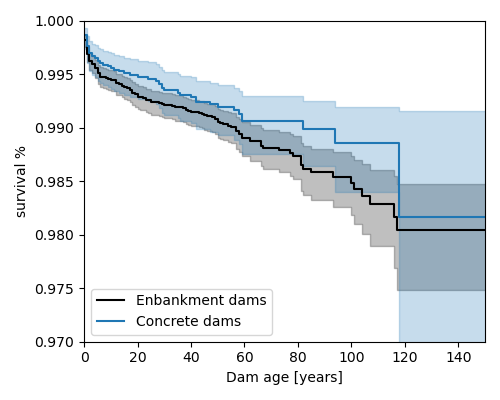

In [77]:
lim_y = 0.97
lim_x = 150

fig = plt.figure(figsize = (5, 4))

data_surv_subset = data_surv_s[(data_surv_s.country != 'China') & 
                               (data_surv_s.year_const >= 1850) & 
                               (data_surv_s.year_const <= 2018)]

kmf_ED = KaplanMeierFitter()
kmf_GC = KaplanMeierFitter()

kmf_ED.fit(durations=data_surv_subset[data_surv_subset.type == 'ED']["time_f"], 
           event_observed=data_surv_subset[data_surv_subset.type == 'ED']["failure"])
kmf_GC.fit(durations=data_surv_subset[data_surv_subset.type == 'CG']["time_f"], 
           event_observed=data_surv_subset[data_surv_subset.type == 'CG']["failure"])

ax2 = fig.add_subplot(111)
kmf_ED.plot_survival_function(color='k',ax=ax2, label = 'Enbankment dams')
kmf_GC.plot_survival_function(color='C0',ax=ax2, label = 'Concrete dams')

ax2.set(
    xlabel='Dam age [years]',
    ylabel=f'survival %',
    ylim = (lim_y,1),
    xlim = (0, lim_x))

# ax2.set_yticks([])
ax2.legend(loc = 3)
plt.tight_layout()

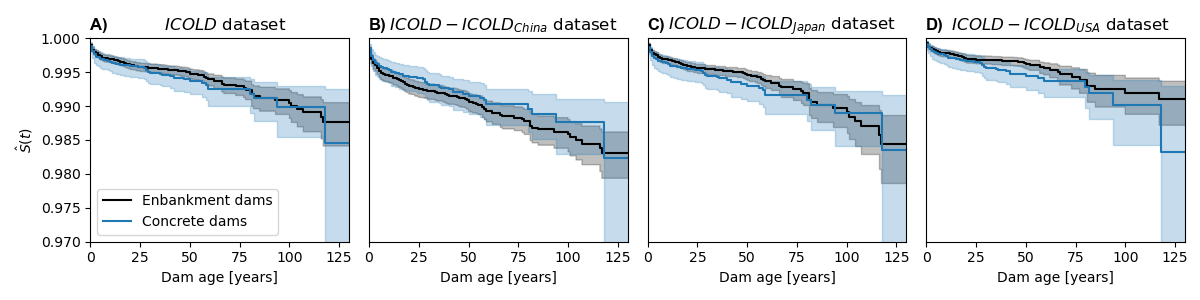

In [75]:
from lifelines import KaplanMeierFitter

lim_y = 0.97
lim_x = 130

kmf_ED = KaplanMeierFitter()
kmf_GC = KaplanMeierFitter()

kmf_ED.fit(durations=data_surv_s[data_surv_s.type == 'ED']["time_f"], event_observed=data_surv_s[data_surv_s.type == 'ED']["failure"])
kmf_GC.fit(durations=data_surv_s[data_surv_s.type == 'CG']["time_f"], event_observed=data_surv_s[data_surv_s.type == 'CG']["failure"])

##### FULL DATABASE

fig = plt.figure(figsize = (12,3))

ax = fig.add_subplot(141)
kmf_ED.plot_survival_function(color='k',ax=ax, label = 'Enbankment dams')
kmf_GC.plot_survival_function(color='C0',ax=ax, label = 'Concrete dams')

ax.set(
    xlabel='Dam age [years]',
    ylabel=f'$\hat S (t)$',
    ylim = (lim_y,1),
    xlim = (0, lim_x))

# ax.get_legend().remove()
ax.legend(loc = 3)
ax.set_title('A)', loc = 'left', family = 'arial', weight='bold')
ax.set_title('  $ICOLD$ dataset', loc = 'center')

#### remove china
data_surv_subset = data_surv_s[data_surv_s.country != 'China']

kmf_ED = KaplanMeierFitter()
kmf_GC = KaplanMeierFitter()

kmf_ED.fit(durations=data_surv_subset[data_surv_subset.type == 'ED']["time_f"], event_observed=data_surv_subset[data_surv_subset.type == 'ED']["failure"])
kmf_GC.fit(durations=data_surv_subset[data_surv_subset.type == 'CG']["time_f"], event_observed=data_surv_subset[data_surv_subset.type == 'CG']["failure"])

ax2 = fig.add_subplot(142)
kmf_ED.plot_survival_function(color='k',ax=ax2, label = 'Enbankment dams')
kmf_GC.plot_survival_function(color='C0',ax=ax2, label = 'Concrete dams')

ax2.set(
    xlabel='Dam age [years]',
    ylim = (lim_y,1),
    xlim = (0, lim_x))

ax2.set_yticks([])
ax2.legend(loc = 3)
ax2.get_legend().remove()
ax2.set_title('B)', loc = 'left', family = 'arial', weight='bold')
ax2.set_title('  $ICOLD - ICOLD_{China}$ dataset', loc = 'center')

### remove india
data_surv_subset = data_surv_s[data_surv_s.country != 'Japan']

kmf_ED = KaplanMeierFitter()
kmf_GC = KaplanMeierFitter()

kmf_ED.fit(durations=data_surv_subset[data_surv_subset.type == 'ED']["time_f"], event_observed=data_surv_subset[data_surv_subset.type == 'ED']["failure"])
kmf_GC.fit(durations=data_surv_subset[data_surv_subset.type == 'CG']["time_f"], event_observed=data_surv_subset[data_surv_subset.type == 'CG']["failure"])

ax2 = fig.add_subplot(143)
kmf_ED.plot_survival_function(color='k',ax=ax2, label = 'Enbankment dams')
kmf_GC.plot_survival_function(color='C0',ax=ax2, label = 'Concrete dams')

ax2.set(xlabel='Dam age [years]',
    ylim = (lim_y,1),
    xlim = (0, lim_x))
        
ax2.set_yticks([])
ax2.legend(loc = 3)
ax2.get_legend().remove()
ax2.set_title('C)', loc = 'left', family = 'arial', weight='bold')
ax2.set_title('  $ICOLD - ICOLD_{Japan}$ dataset', loc = 'center')

#### Remove USA
data_surv_subset = data_surv_s[data_surv_s.country != 'United States of America']

kmf_ED = KaplanMeierFitter()
kmf_GC = KaplanMeierFitter()

kmf_ED.fit(durations=data_surv_subset[data_surv_subset.type == 'ED']["time_f"], event_observed=data_surv_subset[data_surv_subset.type == 'ED']["failure"])
kmf_GC.fit(durations=data_surv_subset[data_surv_subset.type == 'CG']["time_f"], event_observed=data_surv_subset[data_surv_subset.type == 'CG']["failure"])

ax2 = fig.add_subplot(144)
kmf_ED.plot_survival_function(color='k',ax=ax2, label = 'Enbankment dams')
kmf_GC.plot_survival_function(color='C0',ax=ax2, label = 'Concrete dams')

ax2.set(xlabel='Dam age [years]',
    ylim = (lim_y,1),
    xlim = (0, lim_x))

ax2.set_yticks([])
ax2.legend(loc = 3)
ax2.get_legend().remove()
ax2.set_title('D)', loc = 'left', family = 'arial', weight='bold')
ax2.set_title('  $ICOLD - ICOLD_{USA}$ dataset', loc = 'center')

plt.tight_layout()